# Example
We will use the healthcare pipeline again as example. For now, we will look at the `DataCourruption` what-if analysis.

In [1]:
import os
from jenga.corruptions.numerical import Scaling
from example_pipelines import HEALTHCARE_PY
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif import PipelineAnalyzer
from mlwhatif.analysis._data_corruption import DataCorruption
from mlwhatif.utils import get_project_root

INTERMEDIATE_EXTRACTION_ORIG_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                 "data_corruption-orig")
INTERMEDIATE_EXTRACTION_GENERATED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if")
INTERMEDIATE_EXTRACTION_OPTIMISED_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                                      "data_corruption-what-if-optimised")

def corruption(pandas_df):
    pandas_df['num_children'] = 0
    return pandas_df

data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=True)

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .save_original_dag_to_path(INTERMEDIATE_EXTRACTION_ORIG_PATH) \
    .save_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_GENERATED_PATH) \
    .save_optimised_what_if_dags_to_path(INTERMEDIATE_EXTRACTION_OPTIMISED_PATH) \
    .execute()

report = analysis_result.analysis_to_result_reports[data_corruption]

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 3736.0260486602783 ms
2022-07-14 12:49:06.883520: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 12:49:06.941232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
INFO:---RUNTIME: Original pipeline execution took 1248.6348152160645 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 5.370855331420898 m

Let us start by looking at the report generated by the analysis.

In [2]:
report

,column,corruption_percentage,metric_corrupt_test_only,metric_corrupt_train_and_test:
0,income,0.3,0.780822,0.917808
1,income,0.6,0.671233,0.643836
2,income,0.9,0.465753,0.479452
3,num_children,0.3,0.904110,0.931507
4,num_children,0.6,0.890411,0.931507
5,num_children,0.9,0.863014,0.931507


Let us now look at the original pipeline DAG.

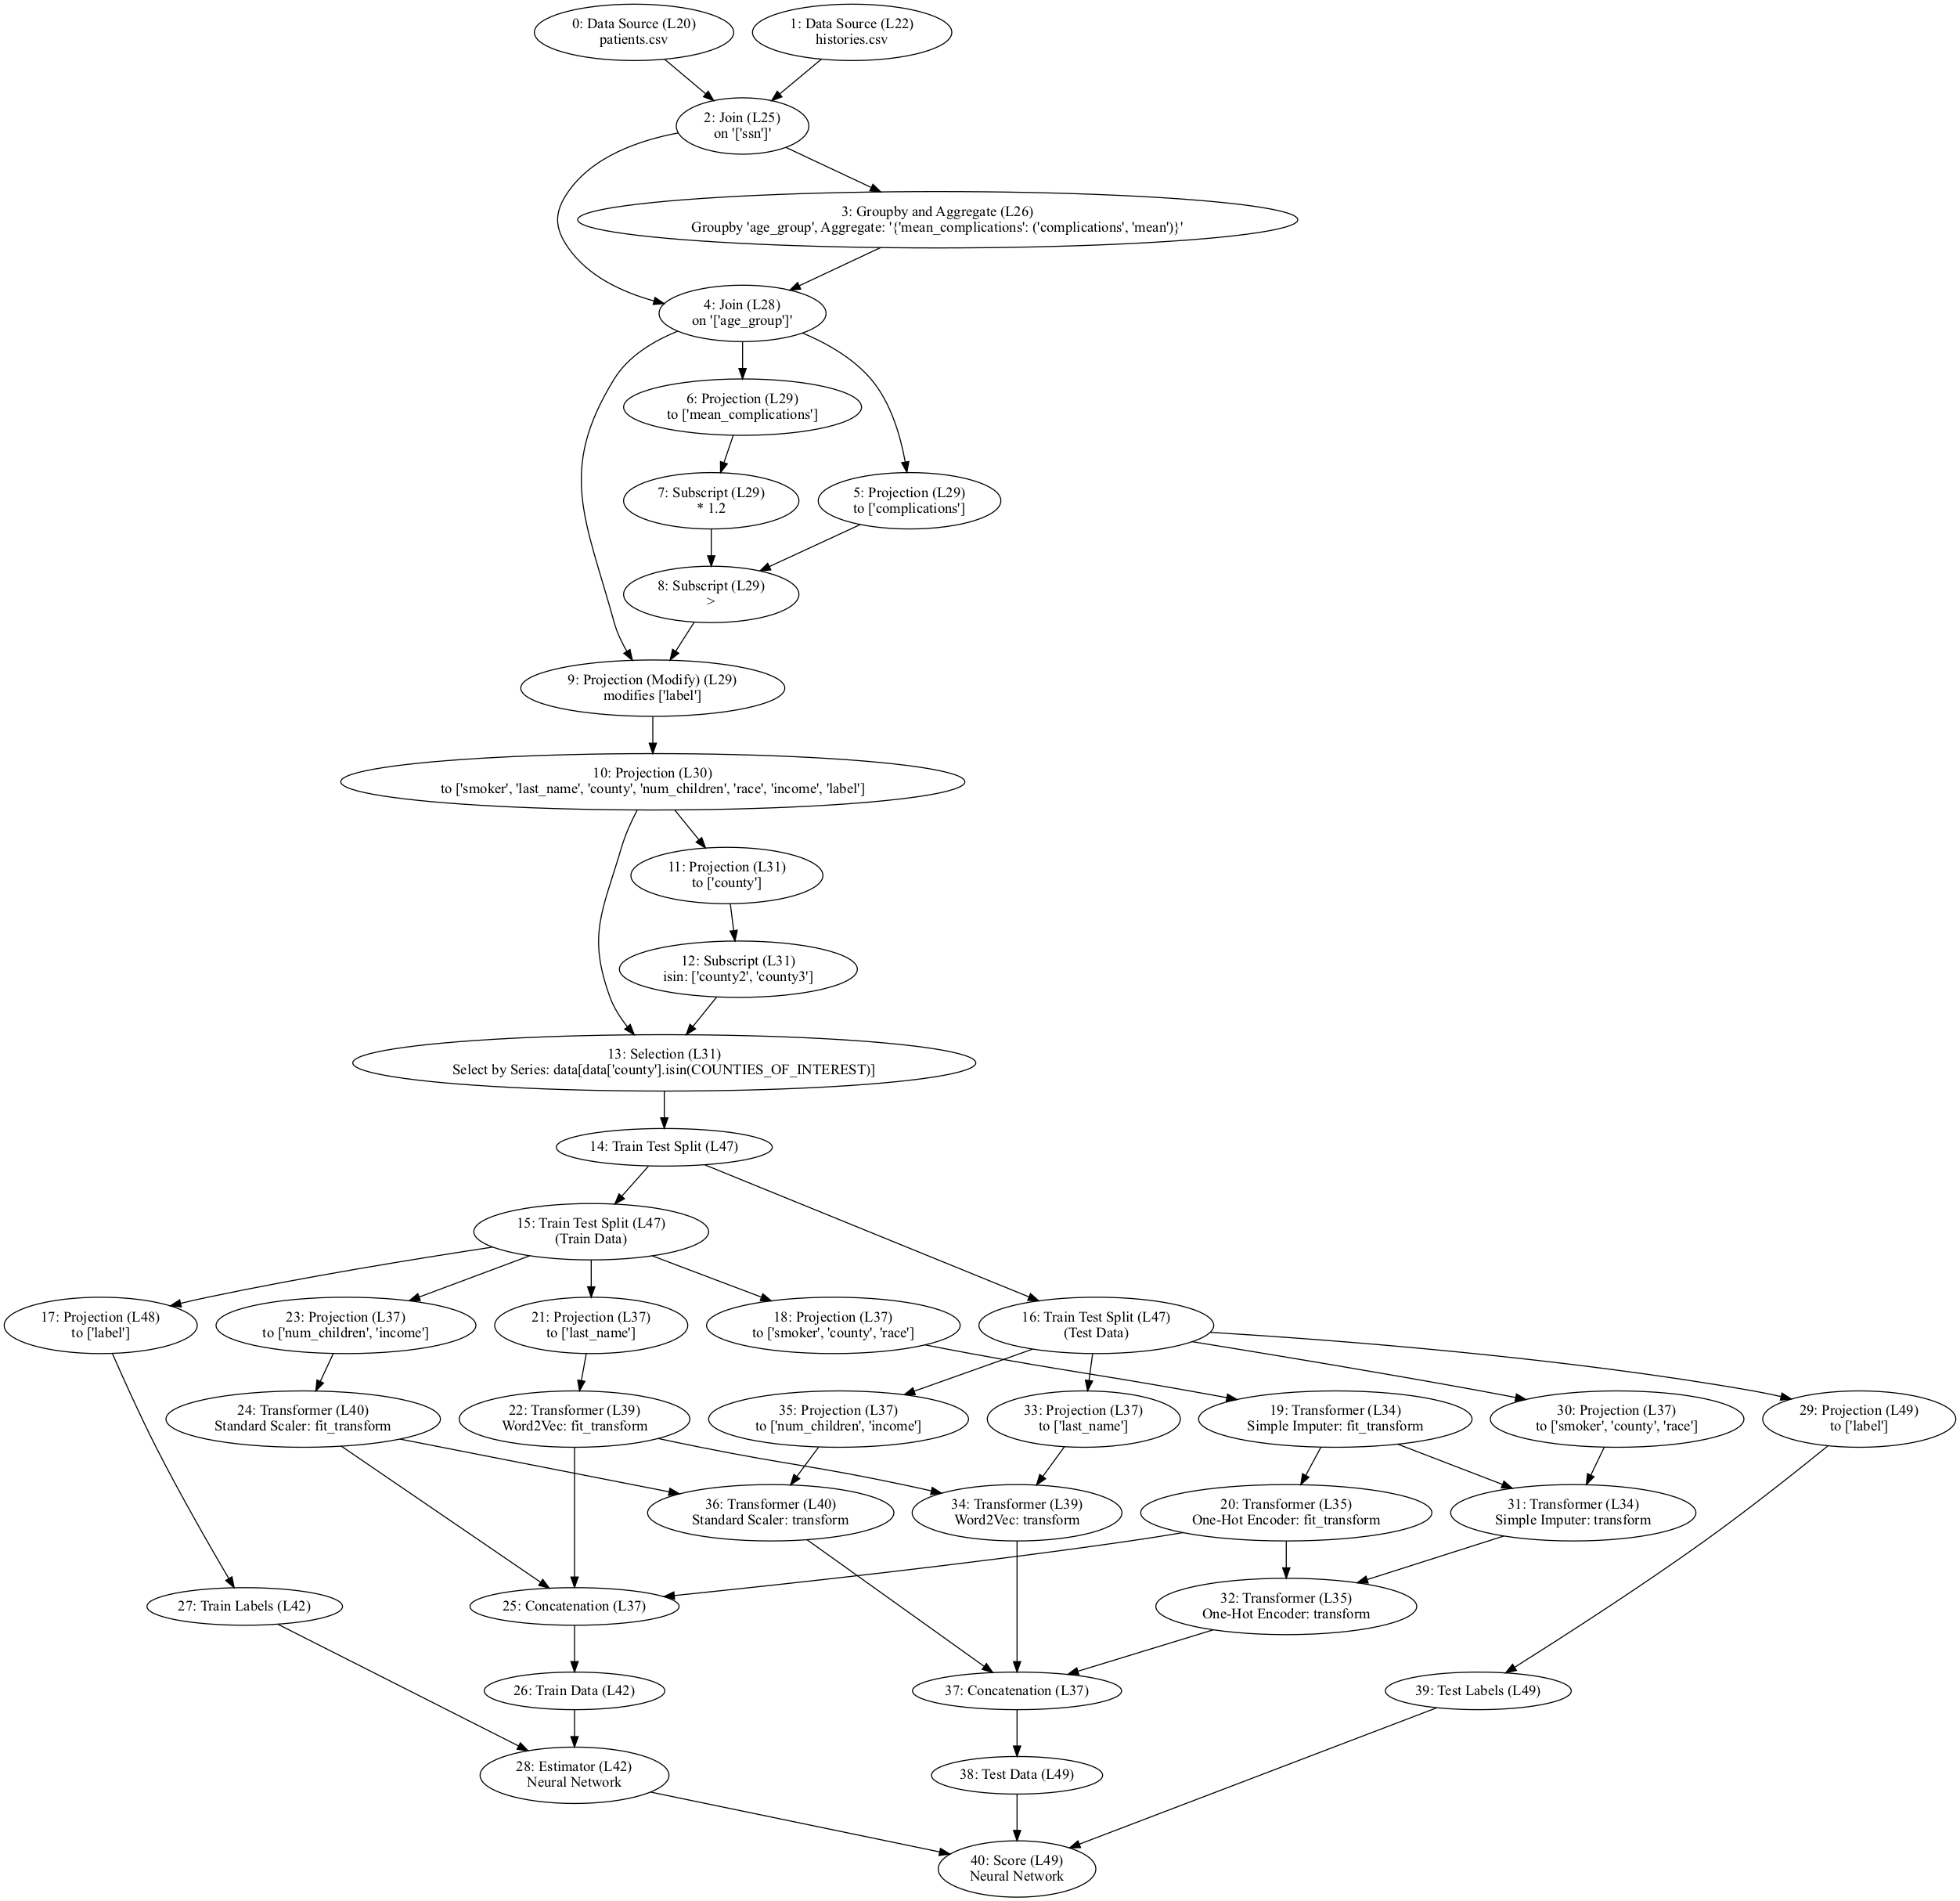

In [3]:
from IPython.display import Image
Image(filename=f"{INTERMEDIATE_EXTRACTION_ORIG_PATH}.png")

This pipeline DAG then gets rewritten to several DAGs we need for our analysis. Let us look at an example. Note the corruption operation now present in the DAG.

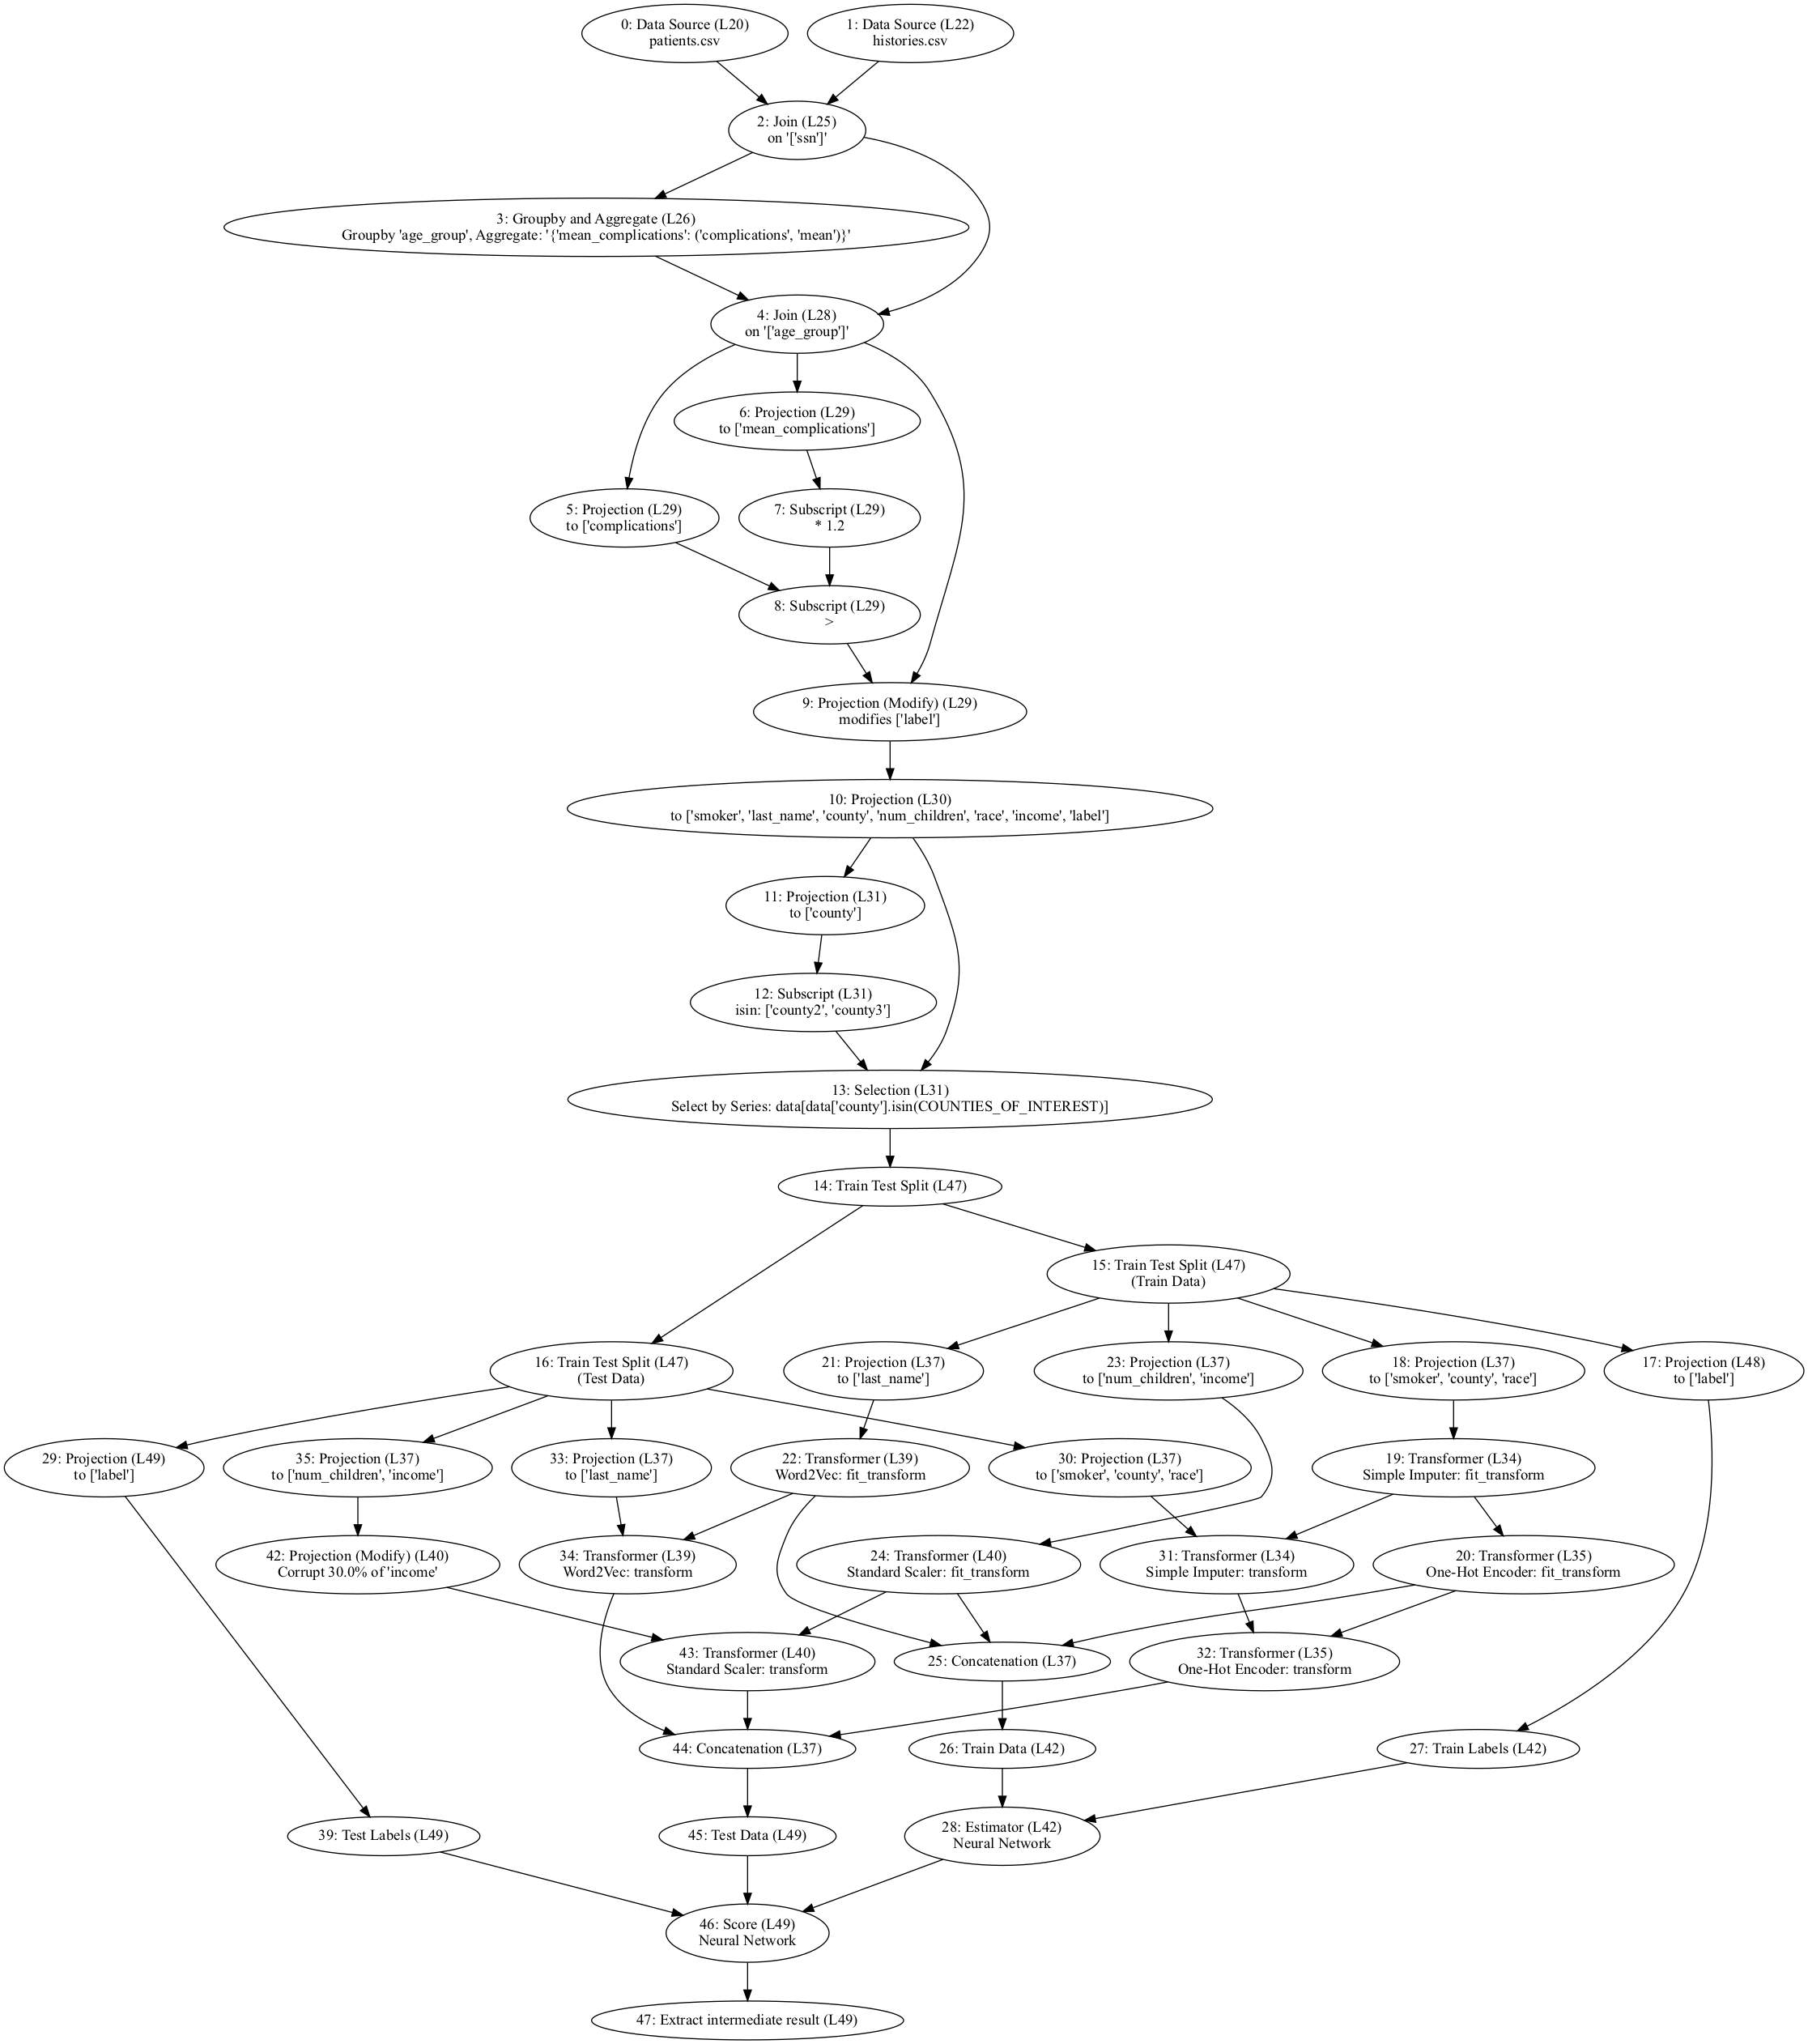

In [4]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_GENERATED_PATH}-DataCorruption-0.png")

We then use a multi-query optimizer to combine all the generated DAGs for efficient execution.

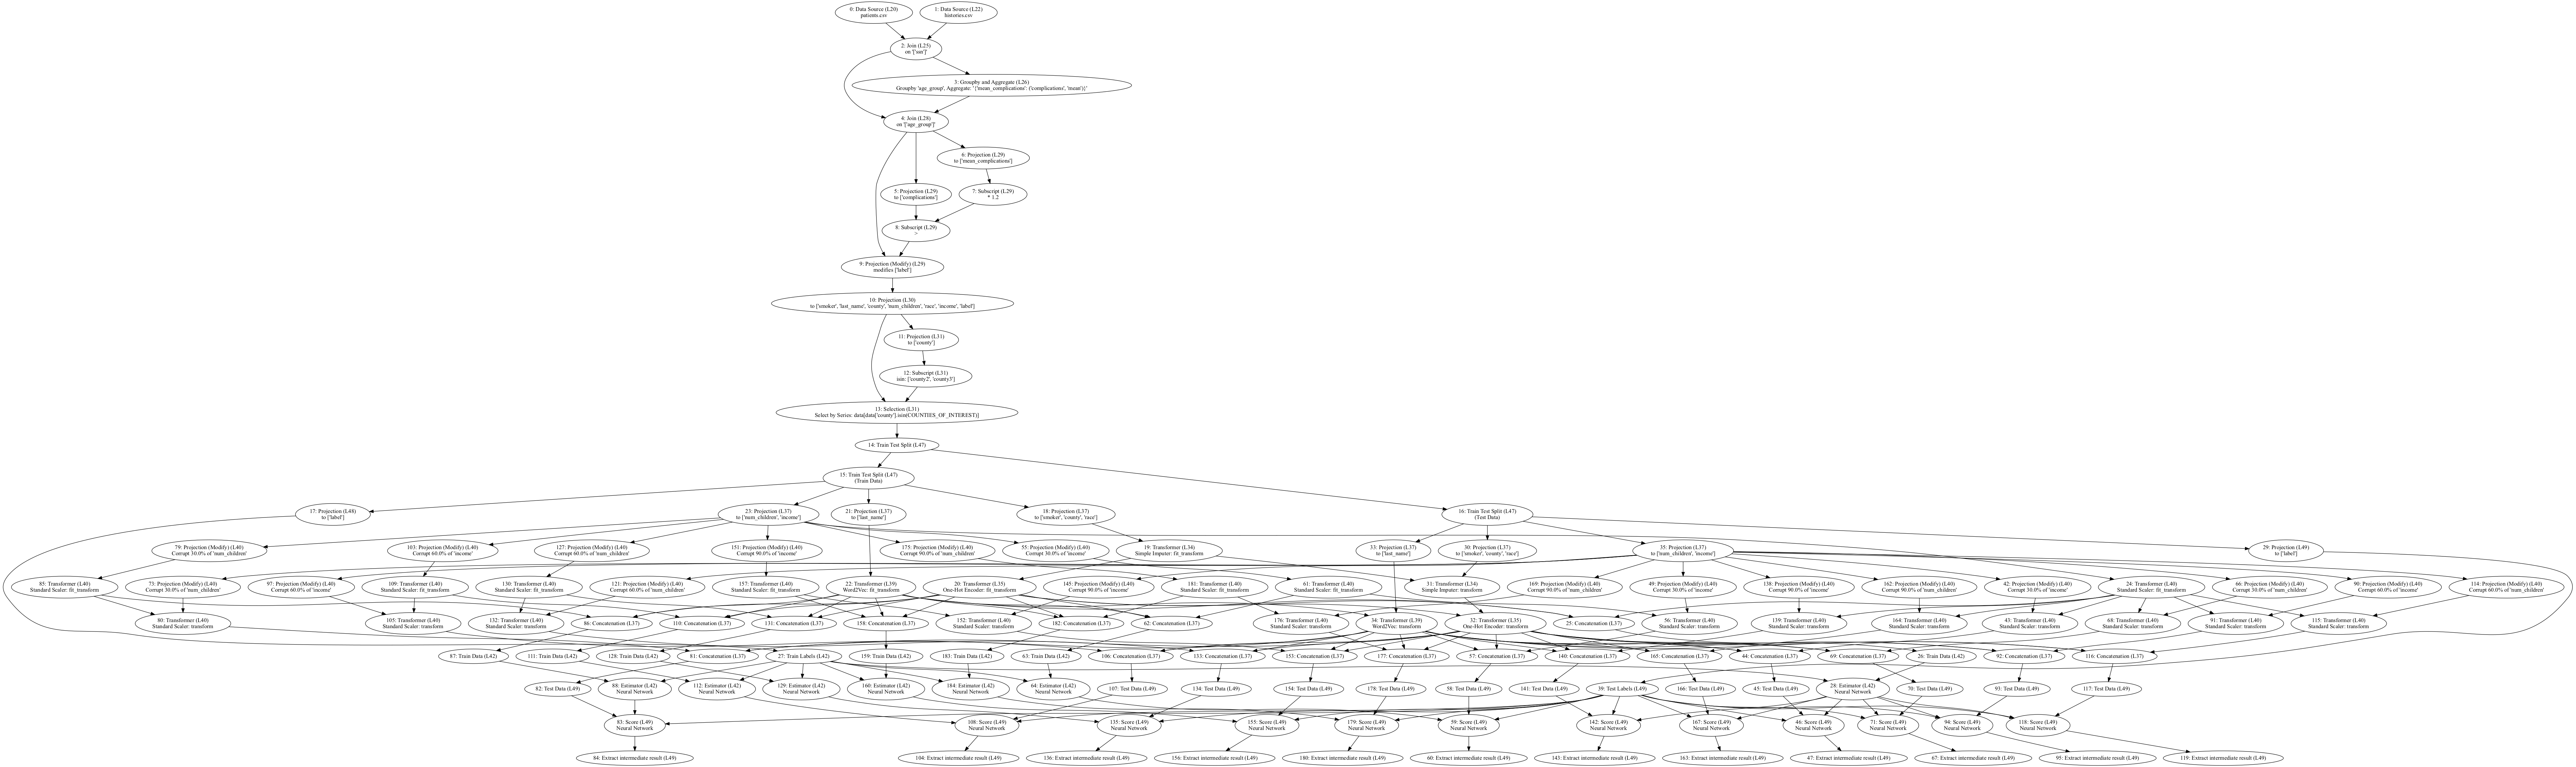

In [5]:
Image(filename=f"{INTERMEDIATE_EXTRACTION_OPTIMISED_PATH}.png")

Let us take a look at how long our analysis takes without this multi-query optimizer.

In [6]:
analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(data_corruption) \
    .execute()

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 7.165193557739258 ms
INFO:---RUNTIME: Original pipeline execution took 1187.6215934753418 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 5.510091781616211 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 12464.915752410889 ms
INFO:Done!


Let us now look at a scenario where we only need to introduce corruptions in the test set, where we do not have model retraining that we cannot optimise away. We can compare without query optimisation...

In [7]:
test_only_data_corruption = DataCorruption({'income':
                                  lambda pandas_df: Scaling(column='income', fraction=1.).transform(pandas_df),
                                  'num_children': corruption},
                                 corruption_percentages=[0.3, 0.6, 0.9],
                                 also_corrupt_train=False)

fast_analysis_result_unopt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(True) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 5.988836288452148 ms
INFO:---RUNTIME: Original pipeline execution took 1033.6930751800537 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 2.1600723266601562 ms
INFO:Executing generated plans
INFO:---RUNTIME: Execution took 6599.647998809814 ms
INFO:Done!


... and with query optimisation.

In [8]:
fast_analysis_result_opt = PipelineAnalyzer \
    .on_pipeline_from_py_file(HEALTHCARE_PY) \
    .skip_multi_query_optimization(False) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .add_what_if_analysis(test_only_data_corruption) \
    .execute()

INFO:Running instrumented original pipeline...
INFO:Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
INFO:---RUNTIME: Importing and monkey-patching took 6.593942642211914 ms
INFO:---RUNTIME: Original pipeline execution took 1152.8830528259277 ms (excluding imports and monkey-patching)
INFO:Starting execution of 1 what-if analyses...
INFO:Start plan generation for analysis DataCorruption...
INFO:---RUNTIME: Plan generation took 2.5873184204101562 ms
INFO:Performing Multi-Query Optimization
INFO:---RUNTIME: Multi-Query Optimization took 2.608060836791992 ms
INFO:Executing generated plan
INFO:---RUNTIME: Execution took 1215.749979019165 ms
INFO:Done!


The results from the optimised and unoptimised execution are the same, only the randomness involved in model training, which are also present when re-executing the same pipeline multiple times, might lead to minor differences.

In [9]:
fast_report_opt = fast_analysis_result_opt.analysis_to_result_reports[test_only_data_corruption]
fast_report_opt

,column,corruption_percentage,metric_corrupt_test_only
0,income,0.3,0.835616
1,income,0.6,0.657534
2,income,0.9,0.575342
3,num_children,0.3,0.890411
4,num_children,0.6,0.890411
5,num_children,0.9,0.890411


In [10]:
fast_report_unopt = fast_analysis_result_unopt.analysis_to_result_reports[test_only_data_corruption]
fast_report_unopt

,column,corruption_percentage,metric_corrupt_test_only
0,income,0.3,0.726027
1,income,0.6,0.712329
2,income,0.9,0.479452
3,num_children,0.3,0.876712
4,num_children,0.6,0.904110
5,num_children,0.9,0.821918
